In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csc_matrix, linalg as LA

# 1. Construction the matrix X

In [2]:
np.set_printoptions(suppress=1)

In [102]:
def construct_X(M, angles, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    
    D = M**2
    No = len(angles)
    N = No * Np
    
    # coordinate matrix
    C = np.mgrid[M-1:-1:-1, :M].astype(np.float64).reshape(2, -1)
    center = M / 2
    C += 0.5 - center
    
    # convert angles from degrees to radians
    angles = np.unwrap(np.deg2rad(angles))
    
    # matrix of normal vectors for rays
    n = np.column_stack([np.sin(angles), np.cos(angles)])
    
    # position of sensor 0 to sensor coordinate system
    s0 = Np / 2 - 0.5
    
    # projections if pixel onto sensor
    # first dim: angles, 2. dim: j
    p = np.dot(n, C) + s0

#     print(p)
#     weight1, i_ind1 = np.modf(p)
#     print(weight1)
#     i_ind1 = i_ind1.astype(int)
# #     weight, i_ind = np.concatenate((weight1, 1 - weight1)), np.concatenate((i_ind1, i_ind1 + 1))
#     weight, i_ind = weight1, i_ind1
#     mask = np.logical_and(i_ind >= 0, i_ind < Np)
#     for i_o in range(No):
#         x = i_o * D
#         i_ind[x : x+Np] += i_o * Np
# #         i_ind[D*No+x: D*No+x+Np] += x
#     print(i_ind)
#     j_ind = np.nonzero(mask)[0] % D
    
#     return coo_matrix((weight[mask], (i_ind[mask], j_ind)), shape=(N, D), dtype=np.float32)
    
    # lists for building of sparse matrix
    weights, i_ind, j_ind = [], [], []
    
    # find weights for every angle
    for i_o, pixels in enumerate(p):
        pixel_floor = np.floor(pixels).astype(int)
        alpha = pixels - pixel_floor
        sensor_ind = np.concatenate((pixel_floor, pixel_floor+1))
        weight = np.concatenate((1-alpha, alpha))
        mask = np.logical_and(sensor_ind >= 0, sensor_ind < Np)
        
        weights += list(weight[mask])
        i_ind += list(sensor_ind[mask] + i_o * Np)
        j_ind += list(np.nonzero(mask)[0] % D)
    
    return coo_matrix((weights, (i_ind, j_ind)), shape=(N, D), dtype=np.float32).asformat('csc')

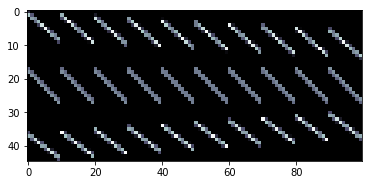

In [104]:
X = construct_X(10, [-33, 1, 42])
X_dense = X.todense()
plt.imshow(X_dense, cmap='bone')

In [108]:
# check if computed matrix is equal to example
X_ex = np.load('hs_tomography/X_example.npy')
assert(np.all(X_ex == X_dense))

# 2. Recovering the image

In [112]:
# alphas = np.load('hs_tomography/alphas_77.npy')
# response = np.load('hs_tomography/y_77.npy')
# M = 77
# Np = 109

alphas = np.load('hs_tomography/alphas_195.npy')
response = np.load('hs_tomography/y_195.npy')
M = 195
Np = 275


X = construct_X(M, alphas, Np)
X.eliminate_zeros()
print(f"Sparsity of X: {X.nnz / np.product(X.shape)}")
X = X.asformat('csc')

Sparsity of X: 0.007231580891056611


In [120]:
beta = LA.lsqr(X, response, atol=1e-6, btol=1e-6)[0]

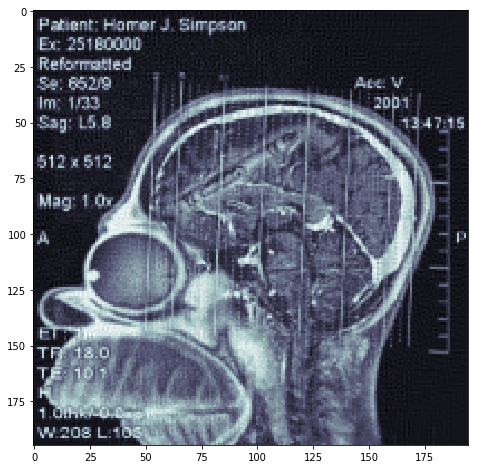

In [121]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(beta.reshape(M,M), cmap='bone')
# ax.plot(np.arange(10)**2)
